In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
import datetime
from datetime import datetime, timedelta, date
import warnings
import os

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#settings
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 1200)
pd.set_option('display.width', 1200)
warnings.filterwarnings("ignore")
%matplotlib inline

#variables
colour=['maroon','r','g','darkgreen','c','teal','b','navy','indigo','m','deeppink','orange','sienna','yellow','khaki','olive','tan','black','grey','brown']

Packages installed


In [2]:
# import all files in Data folder and read into dataframes
dataframes=[]
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        file=filename.split('.')
        file=((file[0]+"_df"))
        if file !="_df":
            filepath=os.path.join(dirname,filename)
            df=pd.read_csv(filepath,sep=",",encoding = "UTF-8")
            exec(f'{file} = df.copy()')
            print(file, df.shape)
            dataframes.append(df)
print('Data imported, you can see the dfs below.')

appearances_df (1175579, 13)
clubs_df (411, 16)
club_games_df (124494, 11)
competitions_df (43, 10)
games_df (62247, 21)
game_events_df (568252, 7)
players_df (28472, 23)
player_valuations_df (424867, 9)
Data imported


## Year, age, and position columns added to dfs 

In [3]:
# Calculate the age of each player
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
# drop players with no date of birth
players_df = players_df[players_df['date_of_birth'].isnull() == False]
now = datetime.now()
players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
players_df['age'] = players_df['age'].round().astype(int) 

# Calculate the contract remaining of each player
players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])
# drop players with no date of birth
players_df = players_df[players_df['contract_expiration_date'].isnull() == False]
now = datetime.now()
players_df['term_days_remaining'] = (players_df['contract_expiration_date']- now).apply(lambda x: x.days) 

# add year to player valuations
player_valuations_df['datetime']=pd.to_datetime(player_valuations_df['datetime'], format="%Y-%m-%d")
player_valuations_df['year']=player_valuations_df['datetime'].dt.year

# add year to player appearances
appearances_df['datetime']=pd.to_datetime(appearances_df['date'], format="%Y-%m-%d")
appearances_df['year']=appearances_df['datetime'].dt.year

#add position to player valuations
position_df=players_df.copy()
position_df=position_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'market_value_in_eur', 'highest_market_value_in_eur', 'agent_name', 'contract_expiration_date', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'image_url', 'last_season', 'url', 'age'], axis=1)
player_valuations_df=player_valuations_df.merge(position_df, left_on='player_id', right_on='player_id')

#add position to appearances
value_df=players_df.copy()
value_df=value_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'sub_position', 'highest_market_value_in_eur', 'agent_name', 'contract_expiration_date', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'image_url', 'last_season', 'url', 'age'], axis=1)
appearances_df1=value_df.merge(appearances_df, left_on='player_id', right_on='player_id')

Data processing complete


## To make better predictions, add some filter on data and visualize it

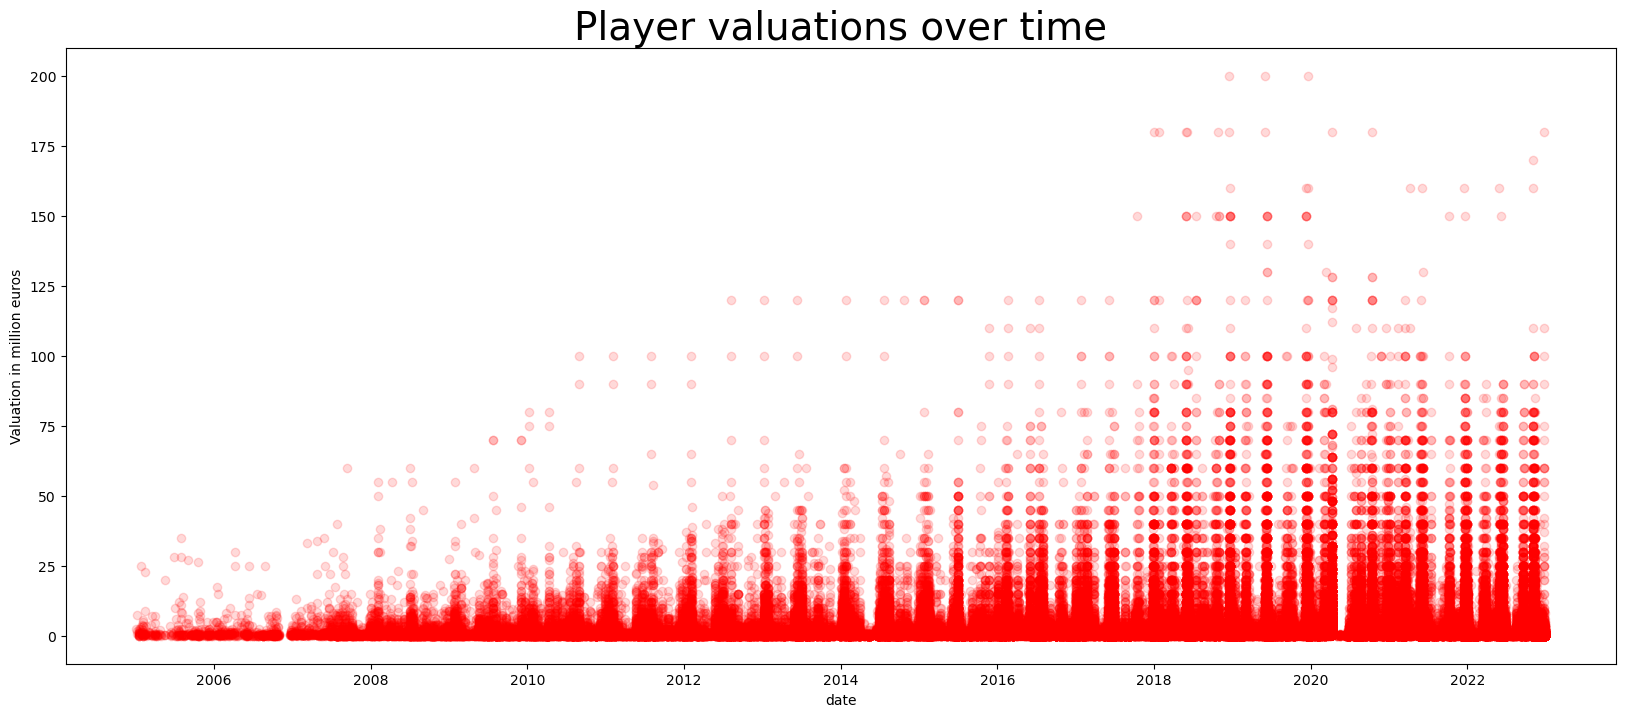

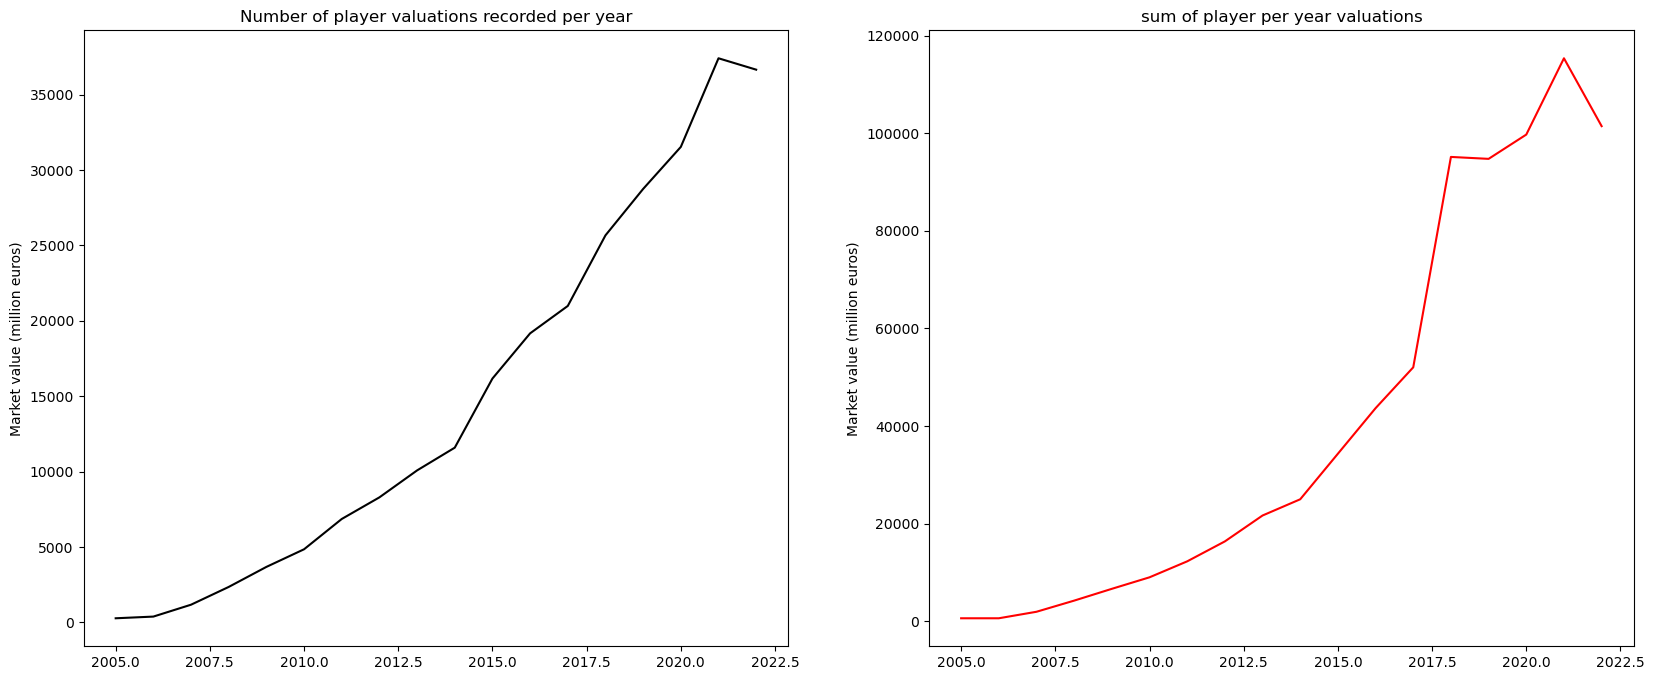

<Figure size 2000x800 with 0 Axes>

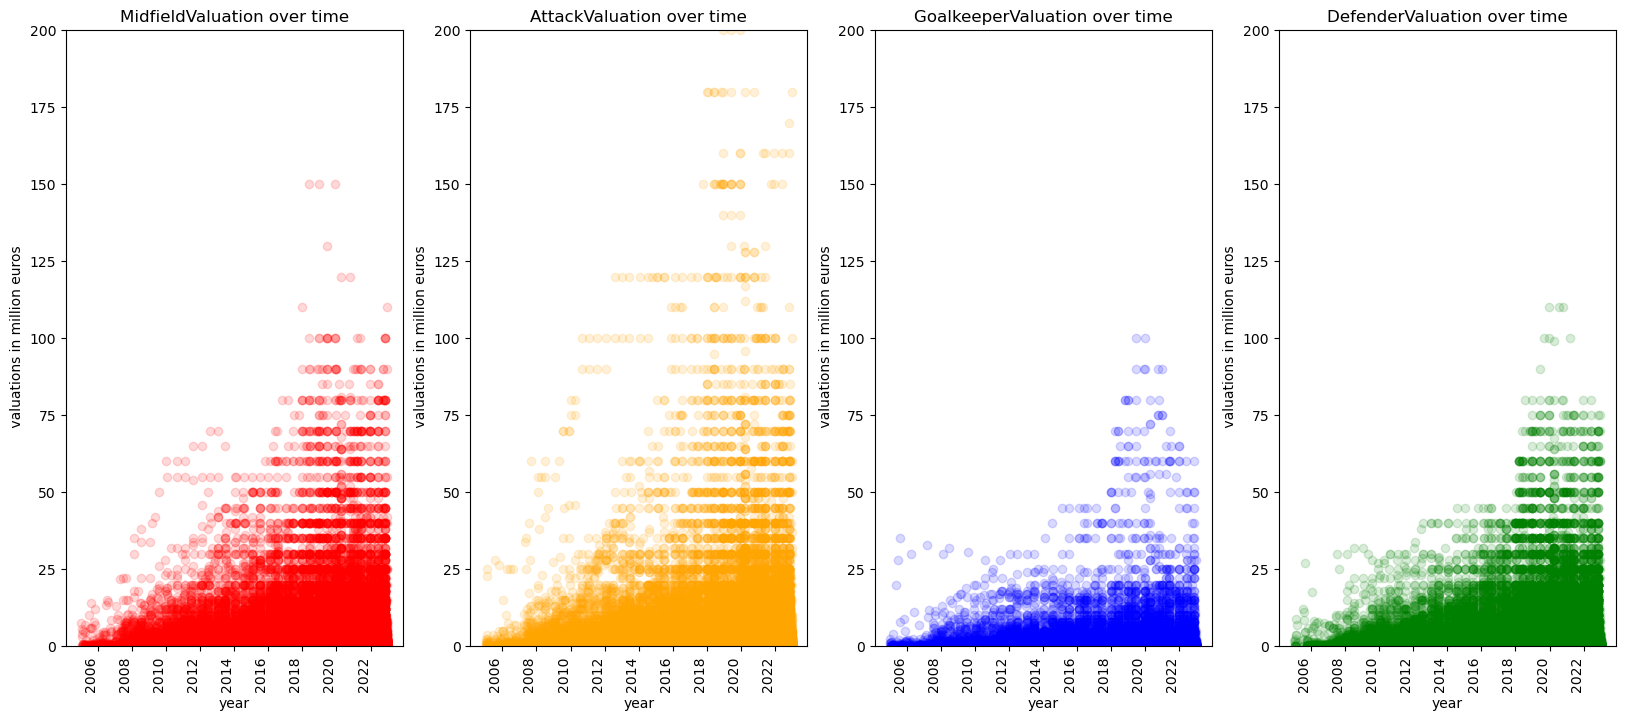

In [13]:
#filter range
player_valuations_df = player_valuations_df[(player_valuations_df.year > 2004 ) & (player_valuations_df.year < 2023 )]
high_value_player_valuations_df = player_valuations_df[(player_valuations_df.market_value_in_eur > 40000000 )]
positions=players_df.position.unique()

plt.figure(figsize=(20,8))
plt.scatter(player_valuations_df['datetime'],y=player_valuations_df['market_value_in_eur']/1000000, c='red',alpha=0.15)
plt.xlabel('date');plt.ylabel('Valuation in million euros')
plt.title('Player valuations over time',fontsize=28)
plt.show()

f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
yeargroups1 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).count() \
    .sort_values(by='year', ascending=True)
yeargroups2 = player_valuations_df.loc[:,['market_value_in_eur', 'year']] .groupby(['year']).sum() \
    .sort_values(by='year', ascending=True)
yeargroups3 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).max() \
    .sort_values(by='year', ascending=True)
yeargroups4 = player_valuations_df.loc[:,['market_value_in_eur', 'year']] .groupby(['year']).min() \
    .sort_values(by='year', ascending=True)
yeargroups5 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).median() \
    .sort_values(by='year', ascending=True)
yeargroups6 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).mean() \
    .sort_values(by='year', ascending=True)

plt.subplot(1, 2, 1)                 
plt.title('Number of player valuations recorded per year')
plt.plot(yeargroups1.index,yeargroups1,color='black')
plt.ylabel('Market value (million euros)')
plt.subplot(1, 2, 2)
plt.title('sum of player per year valuations')
plt.plot(yeargroups2.index,yeargroups2/1000000,color='red')
plt.ylabel('Market value (million euros)')
plt.show()
plt.figure(figsize=(20,8))

plt.figure(figsize=(20,8))
n=1;colour=['yellow','r','orange','b','g']

filtered_positions = positions != 'Missing'
filtered_positions = positions[filtered_positions]


for position in filtered_positions:
    plt.subplot(1,4,n)
    n=n+1
    player_valuations_df1 = player_valuations_df[(player_valuations_df.position==position)]                                             
    plt.scatter(player_valuations_df1['datetime'],y=player_valuations_df1['market_value_in_eur']/1000000, c=colour[n-1],alpha=0.15)
    plt.xlabel('year')
    plt.ylabel(' valuations in million euros')
    plt.title(position+'Valuation over time')
    plt.ylim(0,200)
    plt.xticks(rotation=90, ha='right')
plt.show()  

## Eliminate the player data which has no market value(bcs. we will predit that feature)

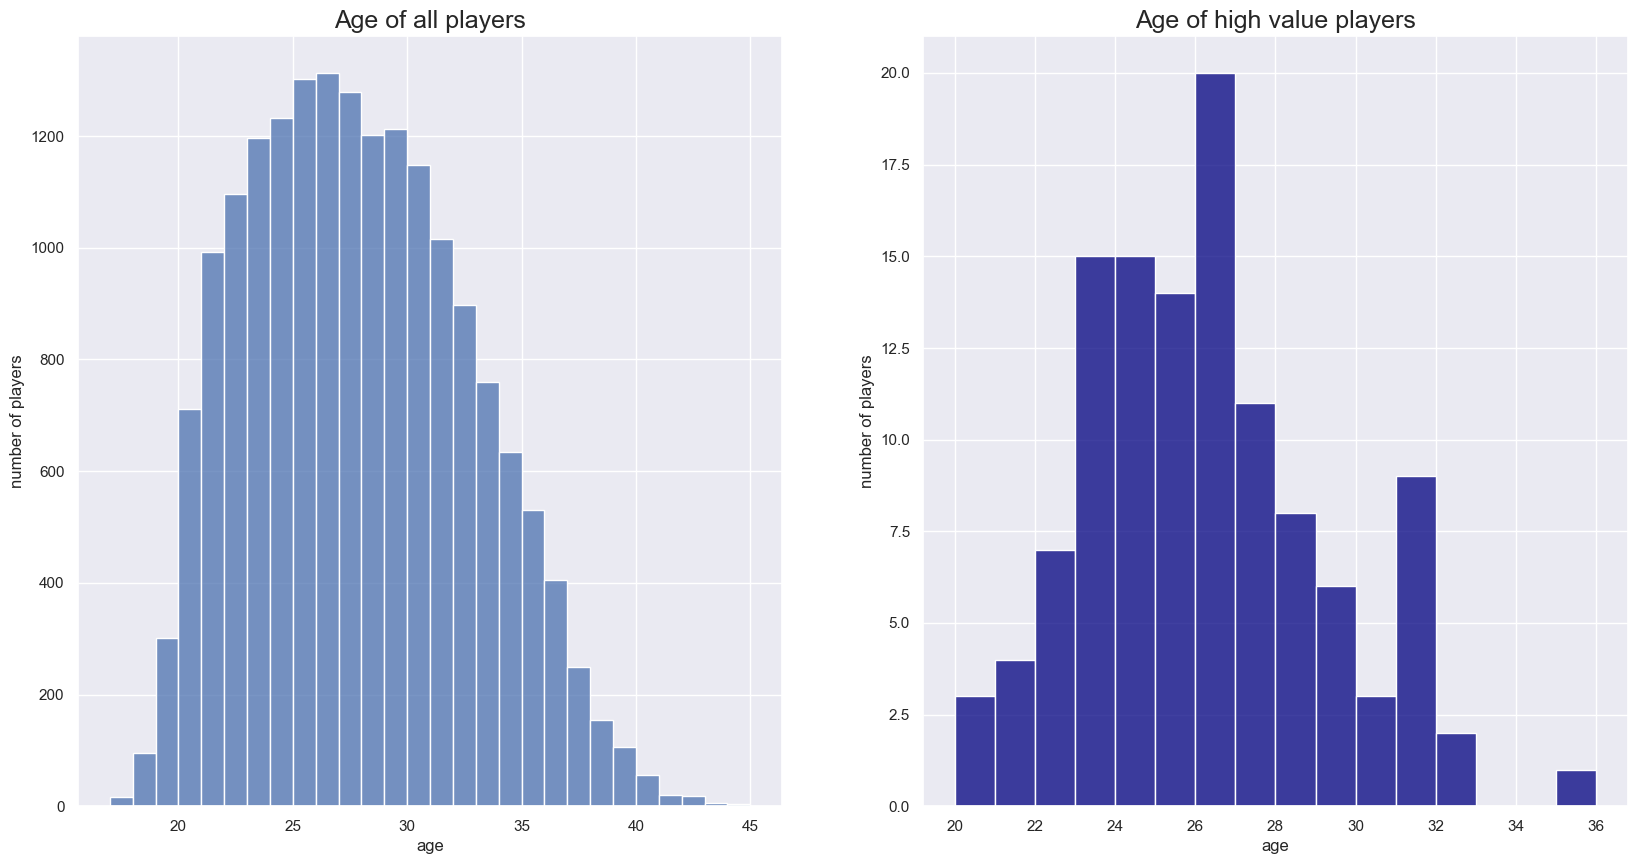

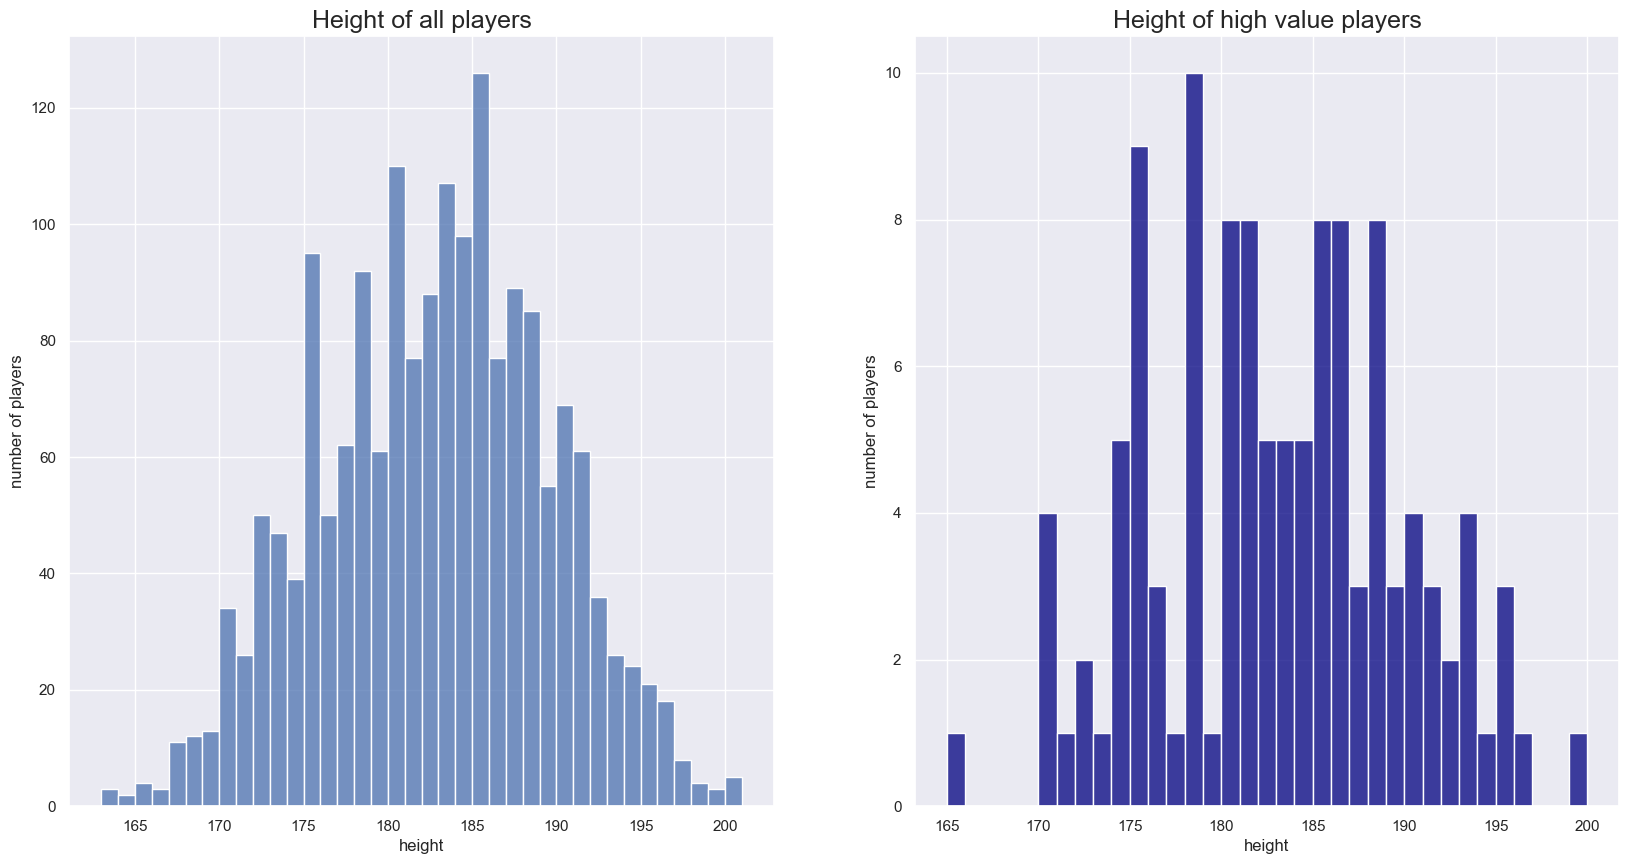

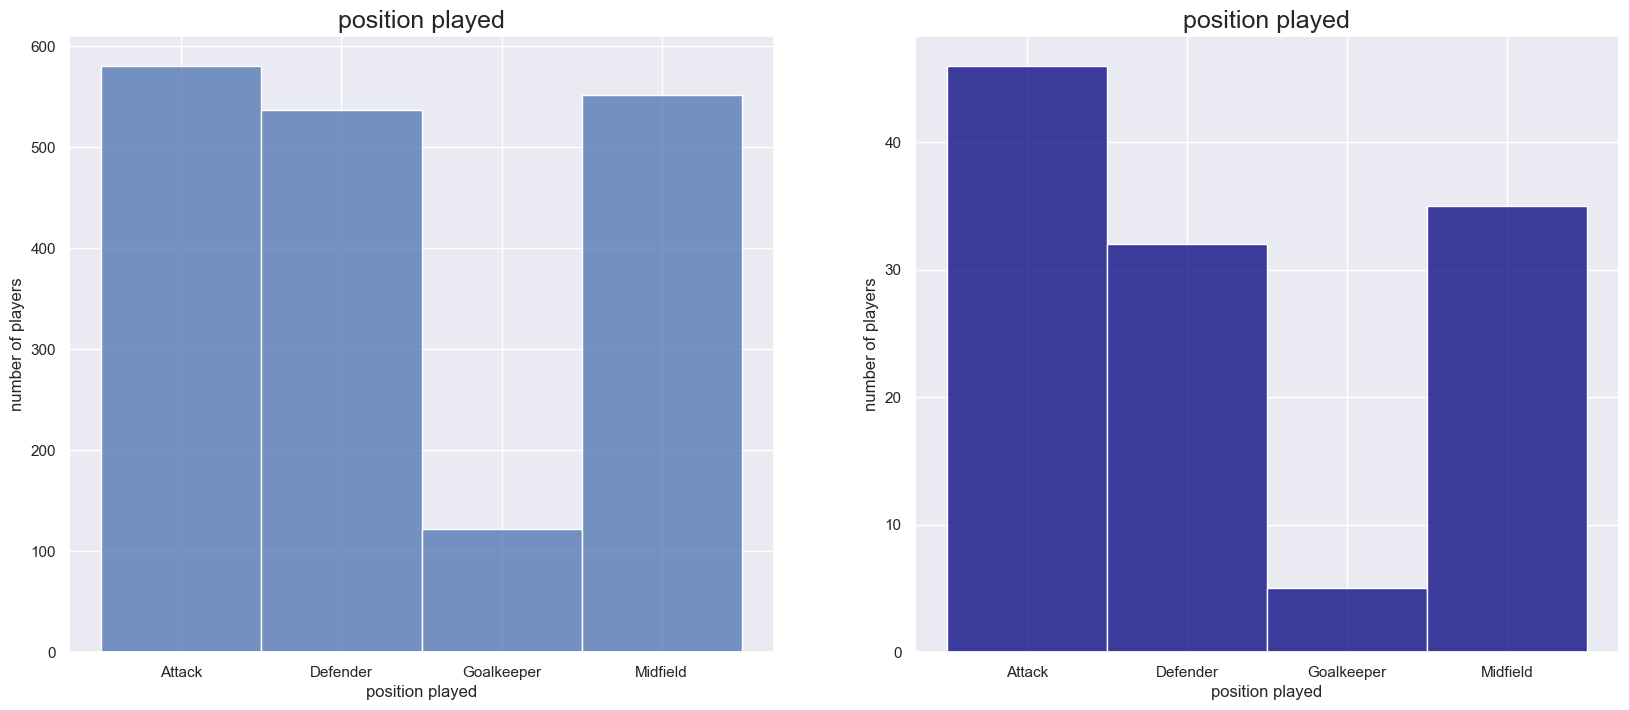

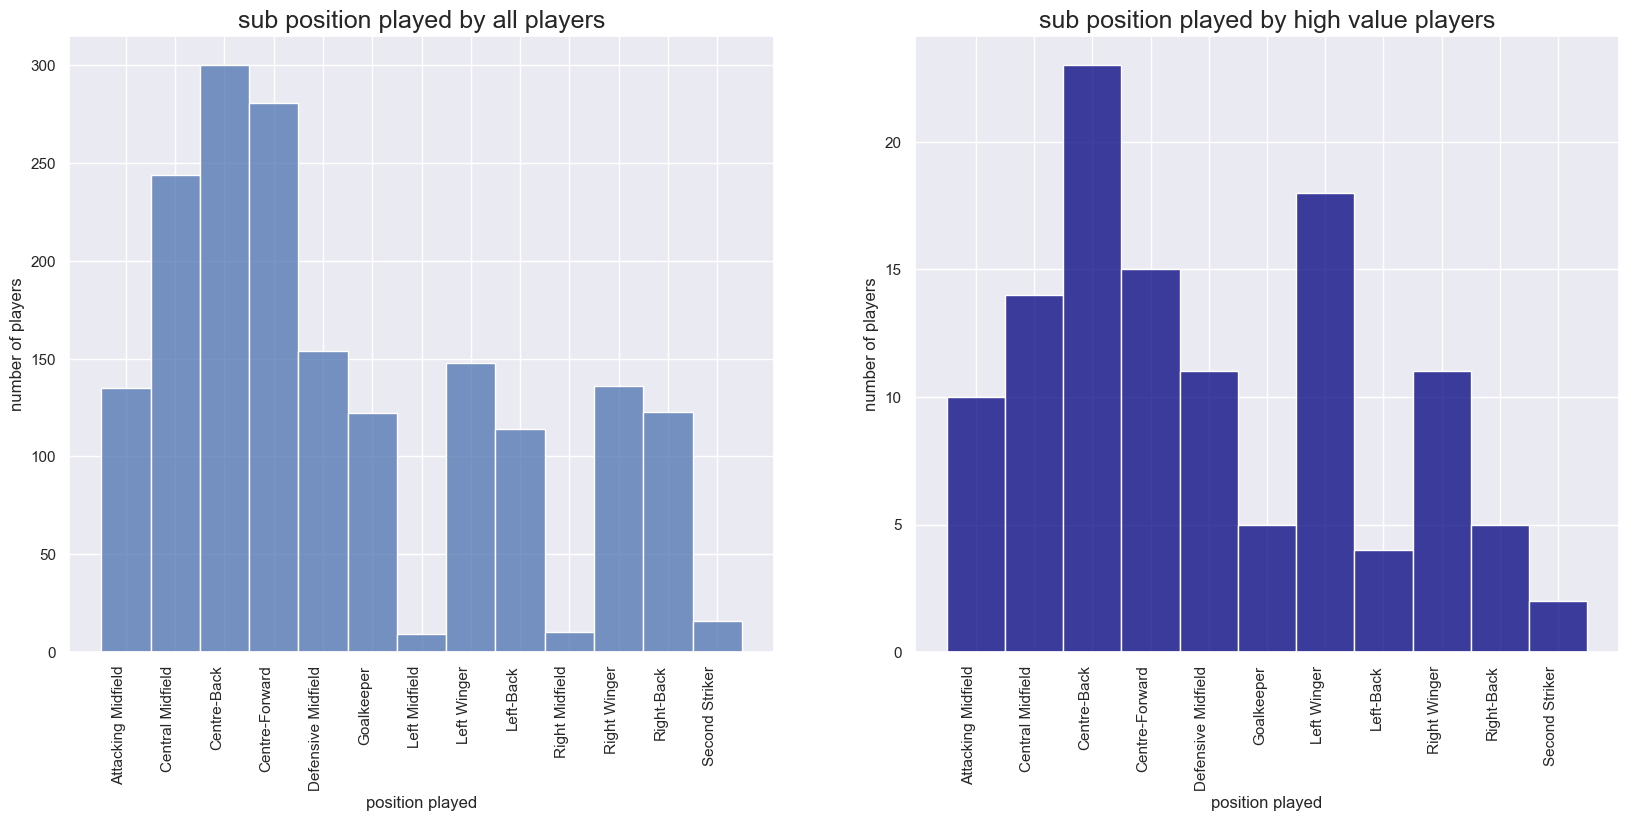

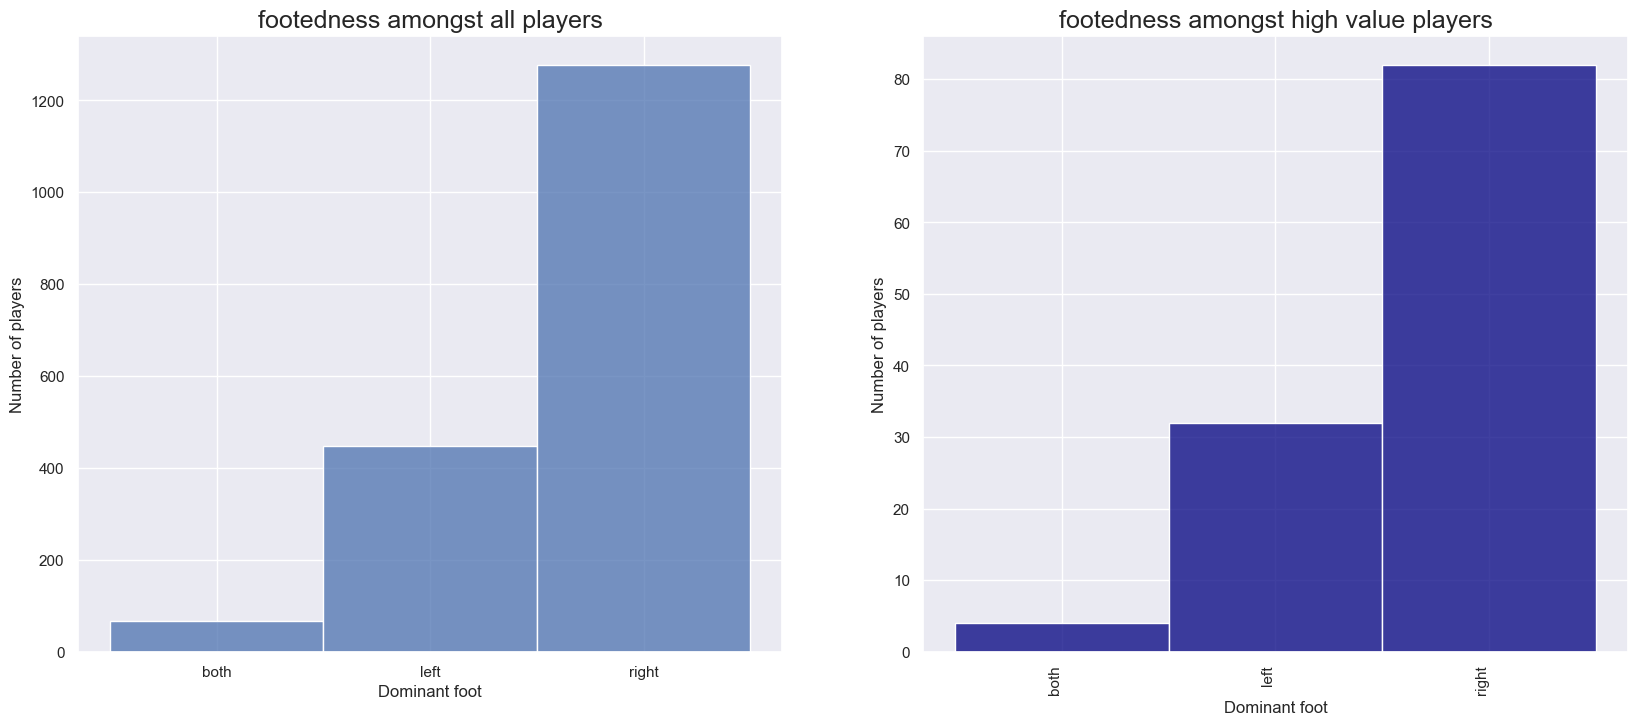

In [15]:
#eliminate players who has no market_value
players_df1 = players_df[players_df.highest_market_value_in_eur.isnull() == False]

#order by Market Value
players_df1 = players_df1.sort_values("highest_market_value_in_eur", ascending = False)

#filter by season and value
players_df1 = players_df[players_df['last_season'] >= 2021]
players_df1 = players_df1[players_df1['highest_market_value_in_eur'] >= 10000000]
high_value_players_df = players_df1[(players_df1.market_value_in_eur > 40000000 )]
positions=players_df.position.unique()

# Player age distribution
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(x='age',data=players_df, binwidth=1,color='b')
plt.title("Age of all players",fontsize=18)
plt.xlabel('age'); plt.ylabel('number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='age',data=high_value_players_df, binwidth=1,color='navy')
plt.title("Age of high value players",fontsize=18)
plt.xlabel('age'); plt.ylabel('number of players')

# Player height distribution
players_df3 = players_df1[players_df1.height_in_cm.isnull() == False]
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(x='height_in_cm',data=players_df3, binwidth=1,color='b')
plt.title("Height of all players",fontsize=18)
plt.xlabel('height'); plt.ylabel('number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='height_in_cm',data=high_value_players_df, binwidth=1,color='navy')
plt.title("Height of high value players",fontsize=18)
plt.xlabel('height'); plt.ylabel('number of players')

# Position data
players_df1 = players_df1.sort_values("position", ascending = True)
high_value_players_df1 = high_value_players_df.sort_values("position", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
plt.title("position played",fontsize=18);plt.grid(True)
sns.histplot(x='position',data=players_df1, binwidth=1,color='b')
plt.xlabel('position played'); plt.ylabel('number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='position',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("position played",fontsize=18);plt.grid(True)
plt.xlabel('position played'); plt.ylabel('number of players')

# Subposition data
players_df1 = players_df1.sort_values("sub_position", ascending = True)
high_value_players_df1 = high_value_players_df.sort_values("sub_position", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.histplot(x='sub_position',data=players_df1, binwidth=1,color='b')
plt.title("sub position played by all players",fontsize=18);plt.grid(True)
plt.xlabel('position played'); plt.ylabel('number of players')
plt.xticks(rotation=90, ha='right');
plt.subplot(1, 2, 2)
sns.histplot(x='sub_position',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("sub position played by high value players",fontsize=18);plt.grid(True)
plt.xlabel('position played'); plt.ylabel('number of players')
plt.xticks(rotation=90, ha='right');

# Footedness data
players_df1 = players_df1.sort_values("foot", ascending = True)
high_value_players_df1 = high_value_players_df1.sort_values("foot", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.histplot(x='foot',data=players_df1, binwidth=1,color='b')
plt.title("footedness amongst all players",fontsize=18);plt.grid(True)
plt.xlabel('Dominant foot'); plt.ylabel('Number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='foot',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("footedness amongst high value players",fontsize=18);plt.grid(True)
plt.xlabel('Dominant foot'); plt.ylabel('Number of players')
plt.xticks(rotation=90, ha='right');

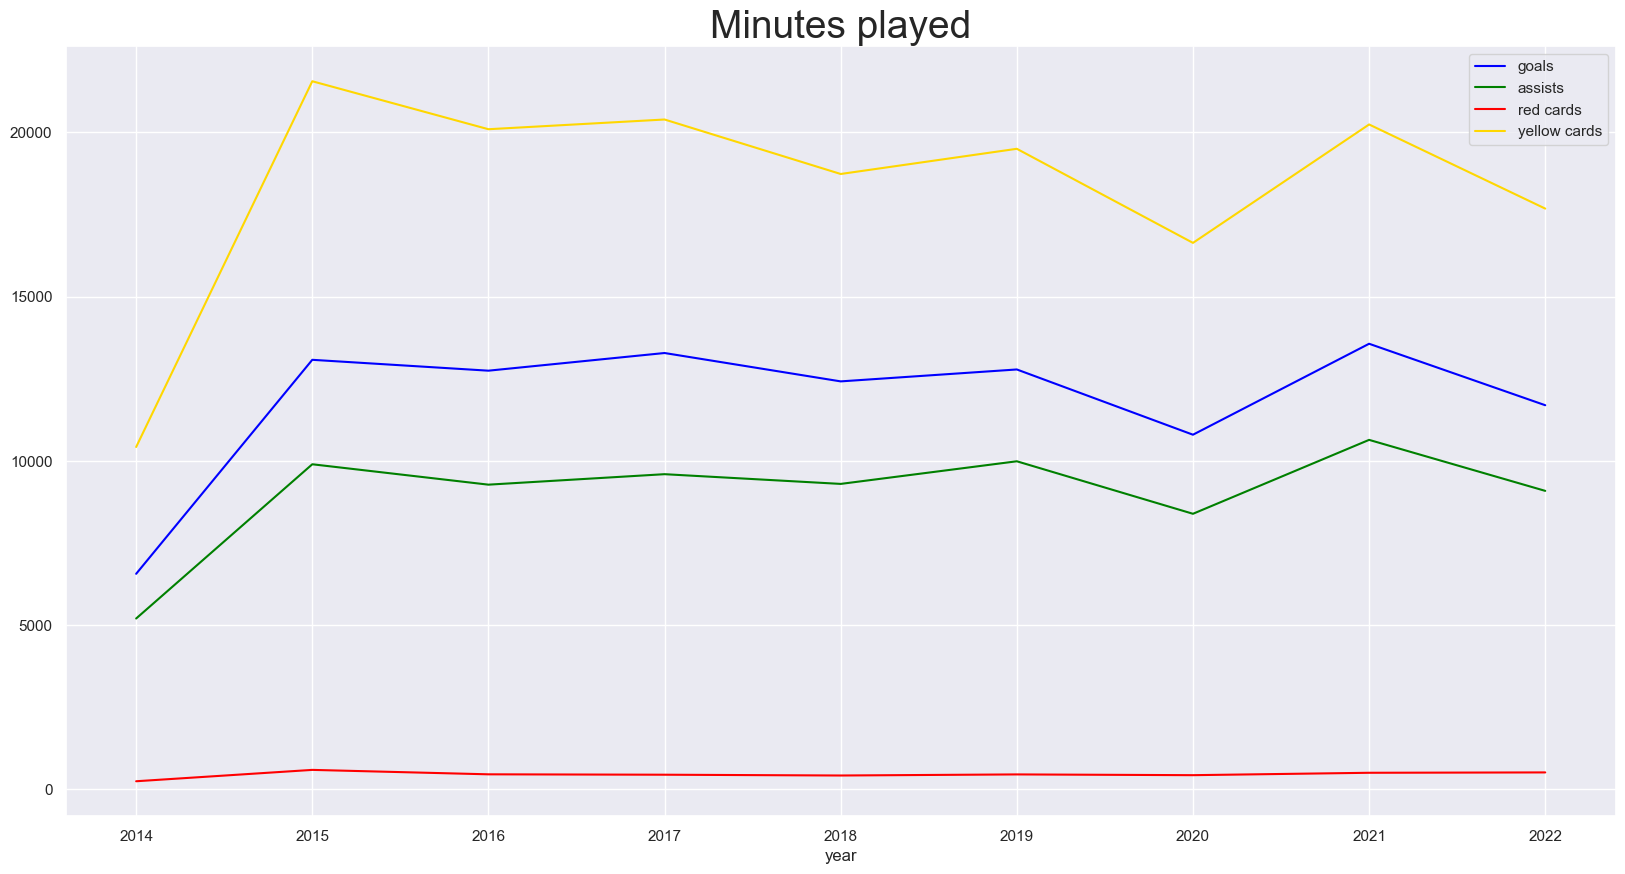

In [17]:
#filter range
appearances_df = appearances_df[(appearances_df.year > 2004 ) & (appearances_df.year < 2023 )]
high_value_appearances_df = appearances_df1[(appearances_df1.market_value_in_eur > 40000000 )]

#Goals, assists and cards
yeargroups1 = appearances_df.loc[:,['goals', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups2 = appearances_df.loc[:,['assists', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups3 = appearances_df.loc[:,['red_cards', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups4 = appearances_df.loc[:,['yellow_cards', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
plt.plot(yeargroups1.index,yeargroups1,color='blue',label='goals')
plt.plot(yeargroups2.index,yeargroups2,color='green',label='assists')
plt.plot(yeargroups3.index,yeargroups3,color='red',label='red cards')
plt.plot(yeargroups4.index,yeargroups4,color='gold',label='yellow cards')
plt.xlabel("year")
plt.title('Minutes played',fontsize=28);plt.legend()
plt.show()

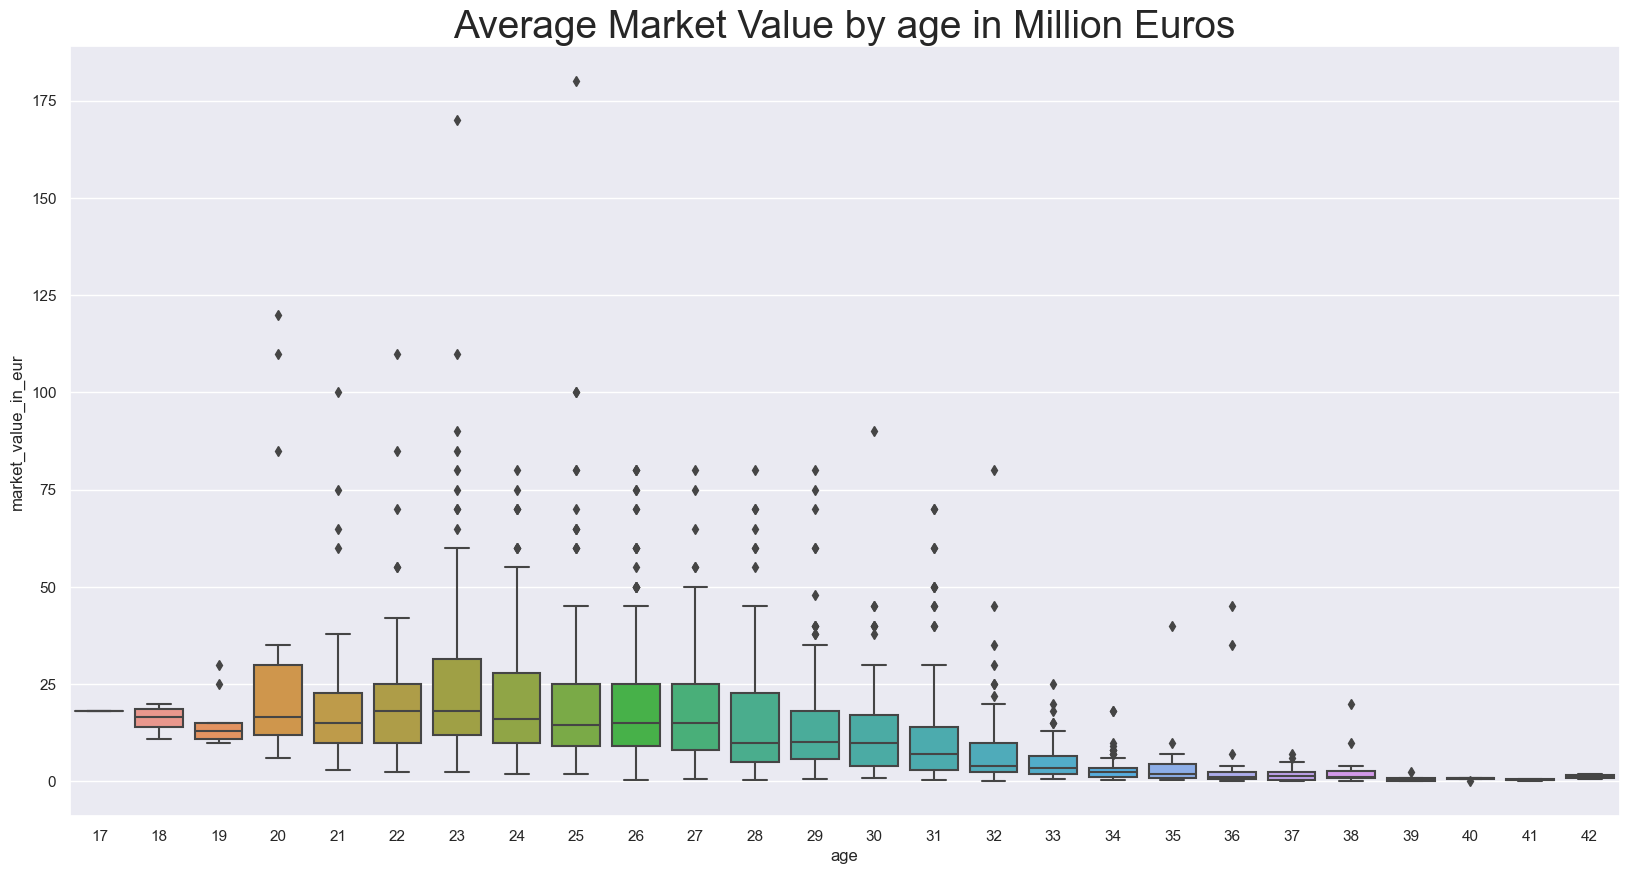

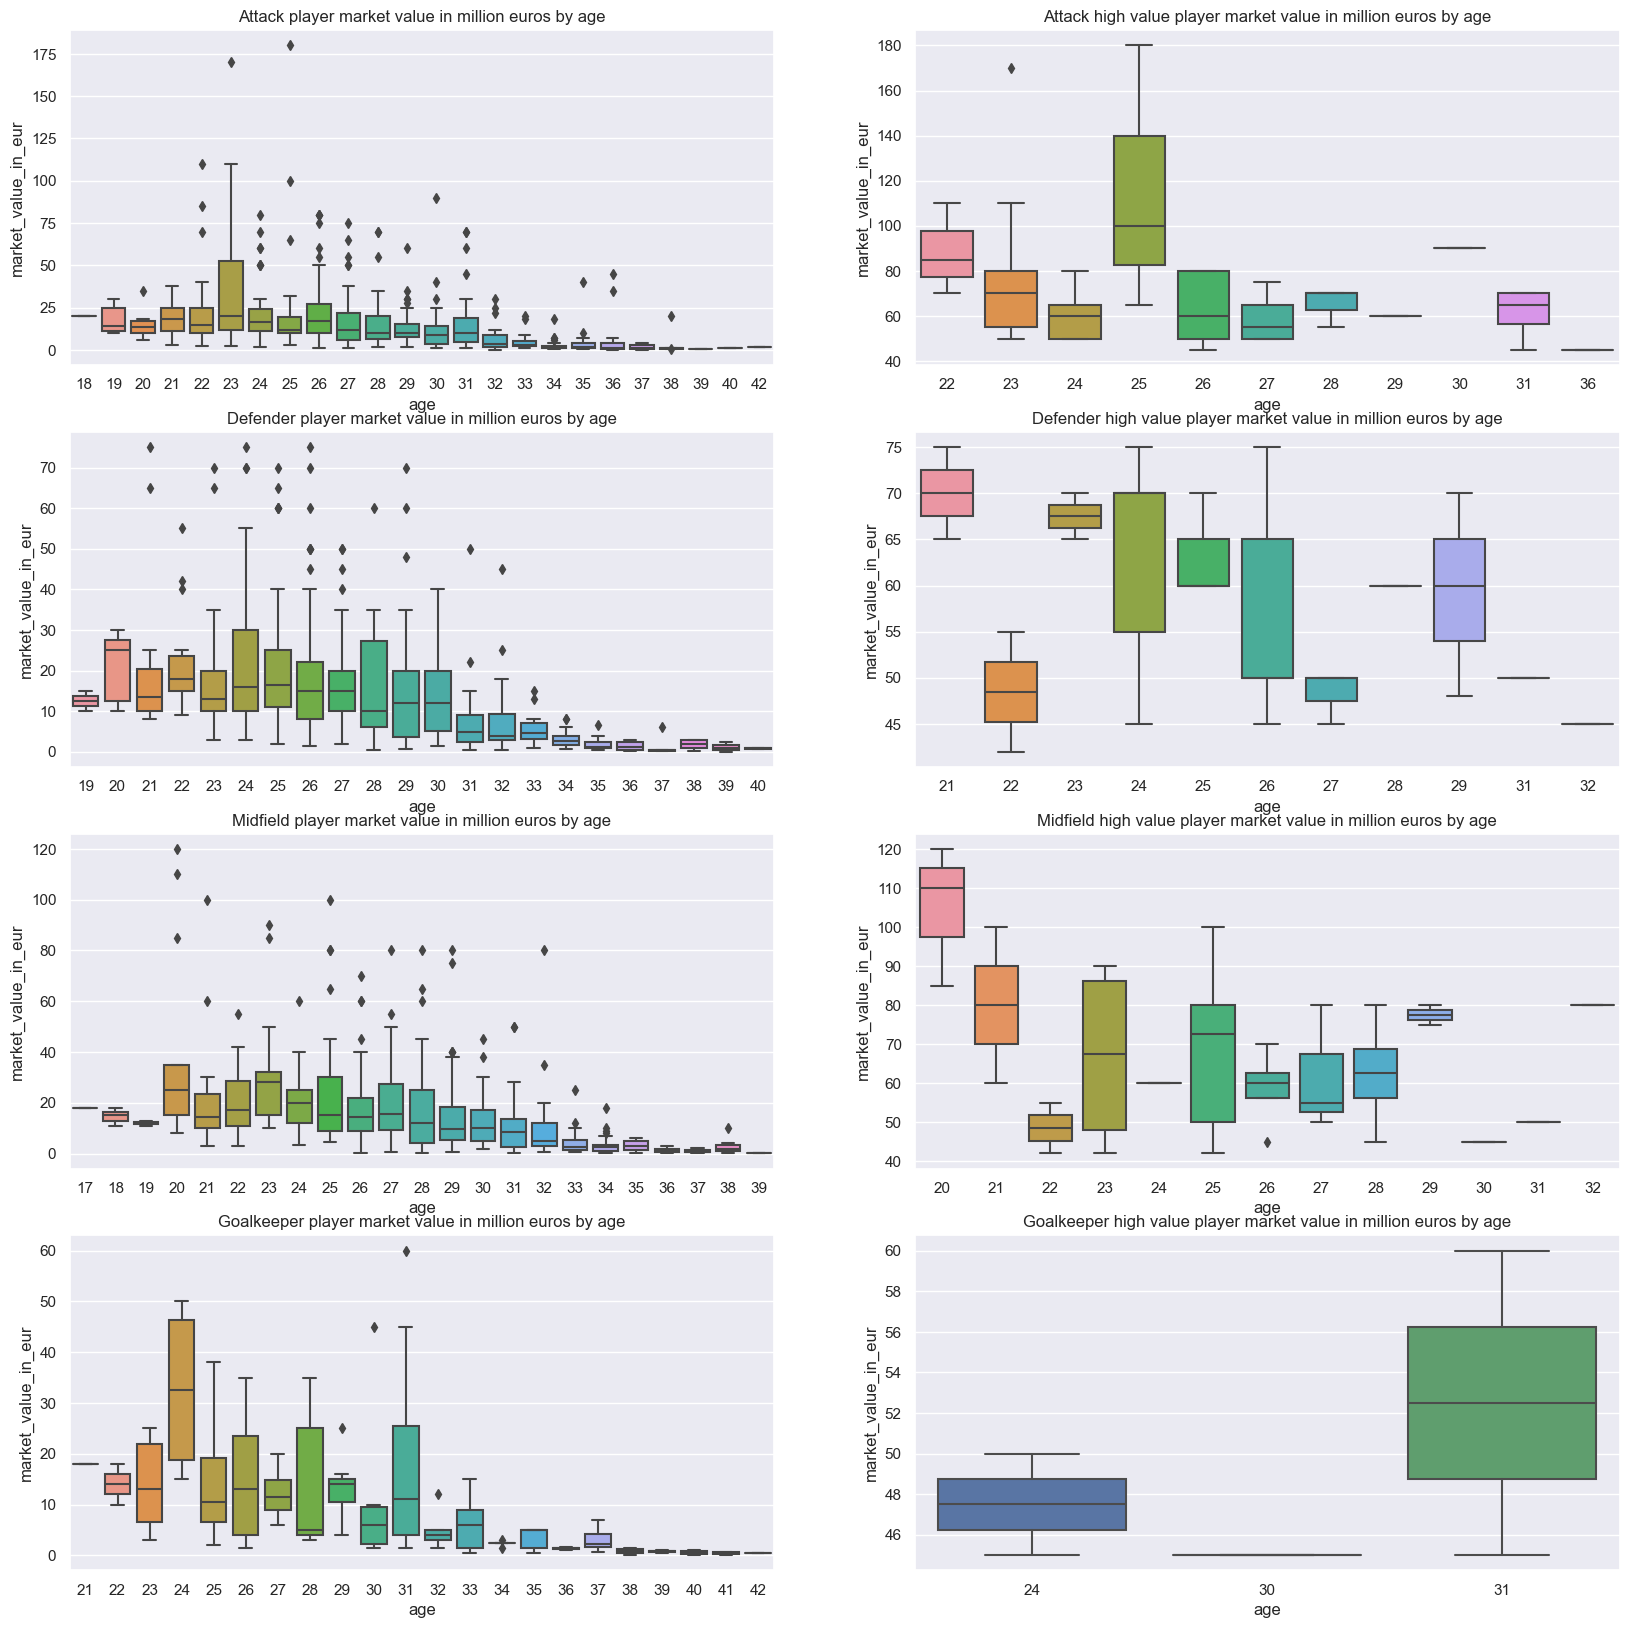

In [19]:
# Market value by age
agegroups = players_df1.loc[:,['market_value_in_eur', 'age']] \
    .groupby(['age']) \
    .mean() \
    .sort_values(by='market_value_in_eur', ascending=False)
sns.set(rc={'figure.figsize':(20,10)})
plt.ylabel('Market value')
sns.boxplot(x=players_df1["age"], y=(players_df1['market_value_in_eur'])/1000000)
plt.title('Average Market Value by age in Million Euros',fontsize=28)
plt.show() 

# Market Value for each position by age
positions=players_df1.position.unique()
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(421);ax2 = f.add_subplot(422);ax3 = f.add_subplot(423);ax4 = f.add_subplot(424)
ax5 = f.add_subplot(425);ax6 = f.add_subplot(426);ax7 = f.add_subplot(427);ax8 = f.add_subplot(428)
n=1
for position in positions:
    plt.subplot(4,2,n); n=n+1 
    players_df2 = players_df1[players_df1['position'] == position]
    agegroups = players_df2.loc[:,['market_value_in_eur', 'age']].groupby(['age']).median().sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=players_df2["age"], y=(players_df2['market_value_in_eur'])/1000000)
    title=str(position+' player market value in million euros by age');plt.title(title)
    plt.subplot(4,2,n); n=n+1
    high_value_players_df2 = high_value_players_df[high_value_players_df['position'] == position]
    agegroups = high_value_players_df.loc[:,['market_value_in_eur', 'age']].groupby(['age']).median().sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=high_value_players_df2["age"], y=(high_value_players_df2['market_value_in_eur'])/1000000)
    title=str(position+' high value player market value in million euros by age'); plt.title(title)
plt.show()

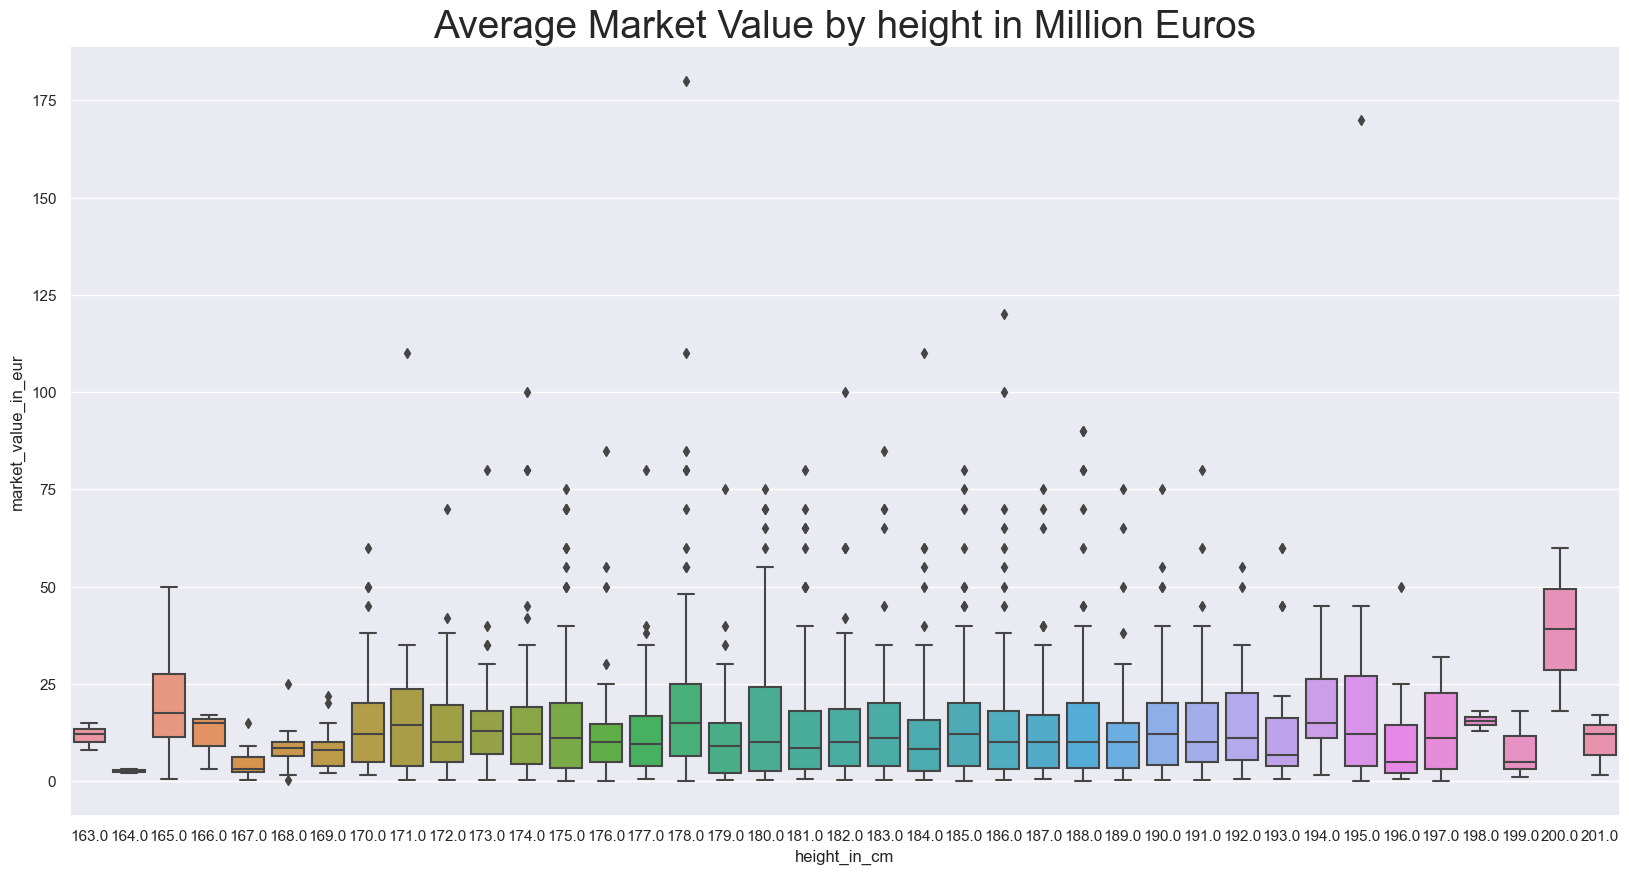

In [22]:
# Drop players with no height
players_df3 = players_df[players_df['height_in_cm'] >= 1]

# Market value by height
heightgroups = players_df1.loc[:,['market_value_in_eur', 'height_in_cm']] \
    .groupby(['height_in_cm']) \
    .mean() \
    .sort_values(by='market_value_in_eur', ascending=False)
sns.set(rc={'figure.figsize':(20,10)})
plt.ylabel('Market value')
sns.boxplot(x=players_df1["height_in_cm"], y=(players_df1['market_value_in_eur'])/1000000)
plt.title('Average Market Value by height in Million Euros', fontsize=28)
plt.show() 

In [23]:
high_value_players_df2=high_value_players_df1.sort_values('market_value_in_eur',ascending = False)
highest_value_players_df2=high_value_players_df1.sort_values('highest_market_value_in_eur',ascending = False)

print((high_value_players_df2[['name',"market_value_in_eur"]]).head(15));print("*****")
print(highest_value_players_df2[['name',"highest_market_value_in_eur"]].head(15));print("*****")

                        name  market_value_in_eur
16633          Kylian Mbappé          180000000.0
23662         Erling Haaland          170000000.0
28454        Jude Bellingham          120000000.0
13963            Bukayo Saka          110000000.0
22335          Jamal Musiala          110000000.0
22121             Phil Foden          110000000.0
24195                  Pedri          100000000.0
16687      Federico Valverde          100000000.0
7977          Victor Osimhen          100000000.0
27197    Aurélien Tchouaméni           90000000.0
5961              Harry Kane           90000000.0
2013   Khvicha Kvaratskhelia           85000000.0
13542         Enzo Fernández           85000000.0
16974          Florian Wirtz           85000000.0
21315         Joshua Kimmich           80000000.0
*****
                  name  highest_market_value_in_eur
16633    Kylian Mbappé                  200000000.0
24392     Lionel Messi                  180000000.0
10634           Neymar                

In [24]:
# print info and describe for each dataframe

for i, df in enumerate(dataframes):
    print("***********")
    print(df.info())
    print(df.describe())

***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1175579 entries, 0 to 1175578
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   appearance_id           1175579 non-null  object
 1   game_id                 1175579 non-null  int64 
 2   player_id               1175579 non-null  int64 
 3   player_club_id          1175579 non-null  int64 
 4   player_current_club_id  1175579 non-null  int64 
 5   date                    1175579 non-null  object
 6   player_name             1175244 non-null  object
 7   competition_id          1175579 non-null  object
 8   yellow_cards            1175579 non-null  int64 
 9   red_cards               1175579 non-null  int64 
 10  goals                   1175579 non-null  int64 
 11  assists                 1175579 non-null  int64 
 12  minutes_played          1175579 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 116.6+ MB
None
        

## Merge dataframes

In [26]:
merged_players_df=players_df.drop(['current_club_id', 'city_of_birth', 'date_of_birth','first_name', 'last_name', 'player_code', 'image_url', 'url'], axis=1)

merged_players_df = merged_players_df.reindex(columns = merged_players_df.columns.tolist() + ['club_value','squad_size','goals','goals_2022','games_2022','assists_2022','minutes_played_2022','goals_against_2022','goals_for_2022','clean_sheet_2022'])
for player_id in merged_players_df.player_id.unique():
    club_id= players_df.current_club_id[(players_df.player_id==player_id)]

    try:
        merged_players_df.club_value[(players_df.player_id==player_id)]=int(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
    except:
        merged_players_df.club_value[(players_df.player_id==player_id)]='NaN'  
    merged_players_df.squad_size[(players_df.player_id==player_id)]=int((clubs_df.squad_size[(clubs_df.club_id==int(club_id))]))

columns=['player_id','games_2022','minutes_played_2022','goals_2022','assists_2022','goals_against_2022','goals_for_2022','clean_sheet_2022','name','position','sub_position','last_season','foot','height_in_cm','age','country_of_citizenship','country_of_birth','current_club_name','club_value','squad_size','current_club_domestic_competition_id','agent_name','contract_expiration_date','term_days_remaining','market_value_in_eur','highest_market_value_in_eur']
merged_players_df=merged_players_df[columns]

games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')

Player and club data merged


In [27]:
games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
season = 2022 


def player_stats(player_id, season, df):
    df = games_and_appearances_df[games_and_appearances_df['player_id'] == player_id]
    df =  df[ df['season'] == season]    
    if (df.shape[0] == 0):
        Out = [(np.nan, season,0,0,0,0,0,0,0,0,0)]
        out_df = pd.DataFrame(data = Out, columns = ['player_id','season','goals','games',
                                                     'assists','minutes_played','goals_for','goals_against','clean_sheet','yellow_cards','red_cards'])
        return out_df    
    else:       
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['away_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id'] 
            else row['home_club_goals'] if row['away_club_id'] == row['player_club_id'] 
            else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
            else 0 if row['goals_against'] > 0
            else np.nan, axis=1)
        df = df.groupby(['player_id',"season"],as_index=False).agg({'goals': 'sum', 'game_id': 'nunique', 
                                                                      'assists': 'sum', 'minutes_played' : 'sum', 'goals_for' : 'sum',
                                                                      'goals_against' : 'sum', 'clean_sheet' : 'sum','yellow_cards':'sum','red_cards':'sum'})
        out_df = df.rename(columns={'game_id': 'games'})
        return out_df

for index in merged_players_df.index:
    id = merged_players_df.loc[index][0]
    name = merged_players_df.loc[index][1]
    stats = player_stats(id, season, games_and_appearances_df)
    try:
        merged_players_df.at[index,'games_{}'.format(season)]= stats['games'][0]
        merged_players_df.at[index,'goals_{}'.format(season)]= stats['goals'][0]
        merged_players_df.at[index,'assists_{}'.format(season)]= stats['assists'][0]
        merged_players_df.at[index,'minutes_played_{}'.format(season)]= stats['minutes_played'][0]
        merged_players_df.at[index,'goals_for_{}'.format(season)]= stats['goals_for'][0]
        merged_players_df.at[index,'goals_against_{}'.format(season)]= stats['goals_against'][0]
        merged_players_df.at[index,'clean_sheet_{}'.format(season)]= stats['clean_sheet'][0]
        merged_players_df.at[index,'yellow_cards_{}'.format(season)]= stats['yellow_cards'][0]
        merged_players_df.at[index,'red_cards_{}'.format(season)]= stats['red_cards'][0]
    except:
        n=n+1     
print('appearance,goal and card data merged')
print(merged_players_df.info());#print(merged_players_df.describe())

appearance,goal and card data merged
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17955 entries, 21 to 28471
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   player_id                             17955 non-null  int64         
 1   games_2022                            17955 non-null  float64       
 2   minutes_played_2022                   17955 non-null  float64       
 3   goals_2022                            17955 non-null  float64       
 4   assists_2022                          17955 non-null  float64       
 5   goals_against_2022                    17955 non-null  float64       
 6   goals_for_2022                        17955 non-null  float64       
 7   clean_sheet_2022                      17955 non-null  float64       
 8   name                                  17955 non-null  object        
 9   position                          

## See correlation of features

Index(['games_2022', 'minutes_played_2022', 'goals_2022', 'assists_2022', 'goals_against_2022', 'goals_for_2022', 'clean_sheet_2022', 'age', 'club_value', 'squad_size', 'term_days_remaining', 'market_value_in_eur', 'highest_market_value_in_eur', 'yellow_cards_2022', 'red_cards_2022'], dtype='object')


<Axes: title={'center': 'Pearson Correlation of Features'}>

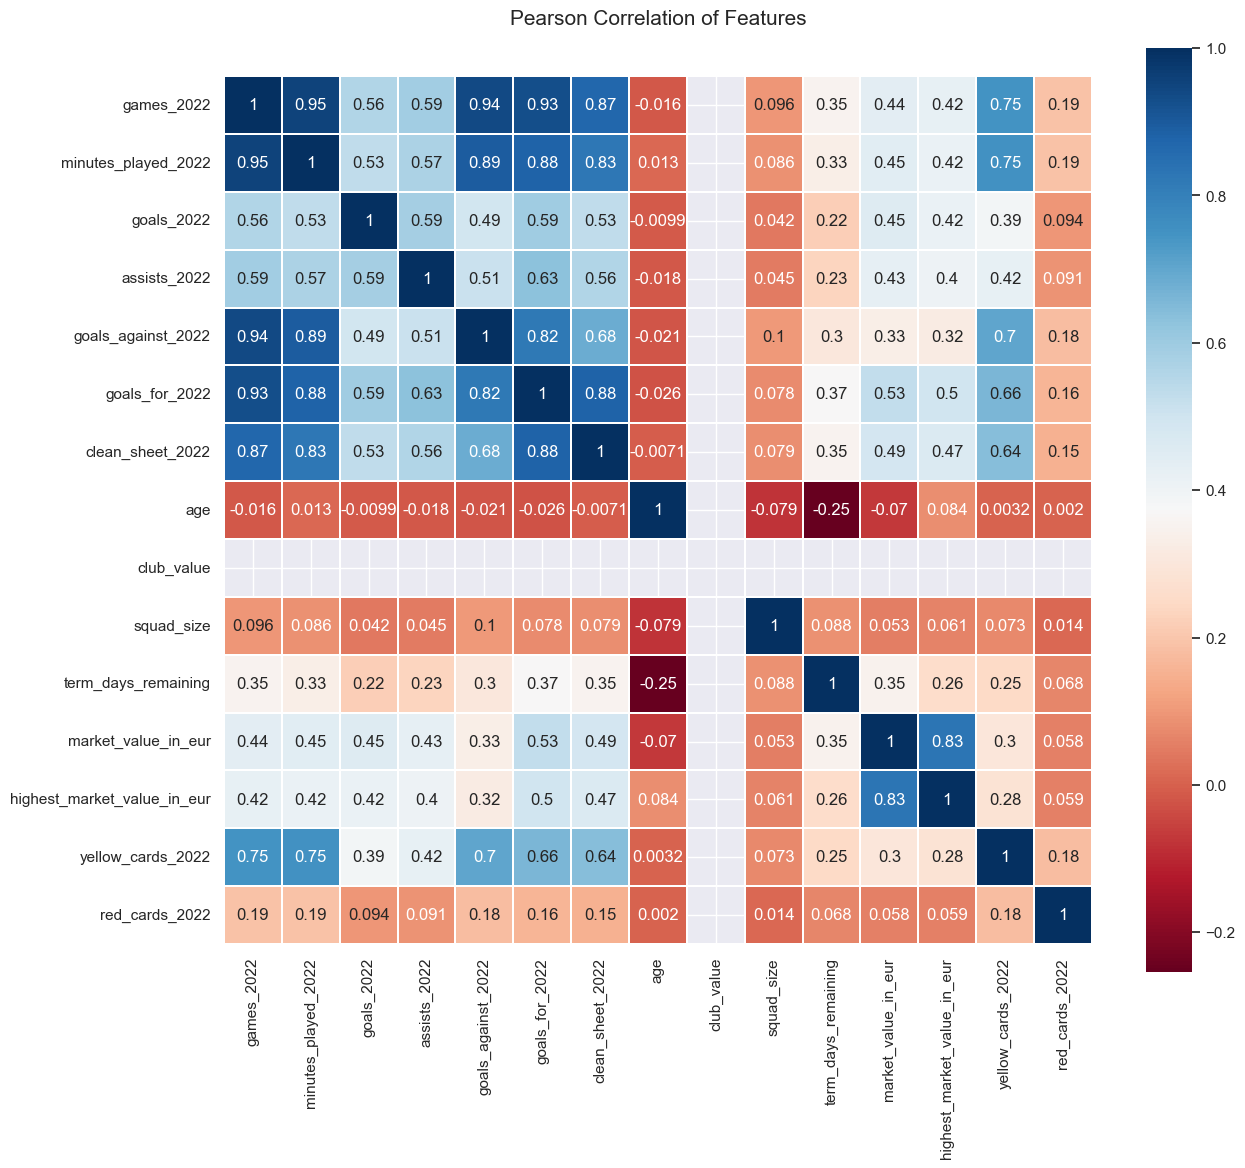

In [28]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
features_df=merged_players_df.drop(['player_id','name','position','sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date'],axis=1)
print(features_df.columns)
sns.heatmap(features_df.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

## Final Comment

### We can observe that goals, played minutes, and played asissts have really nice effect on Market Value. But without a doubt, the best column is 'Highest Market Value' as expected.